In [45]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd

from graspy.plot import heatmap

from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, to_distance_mtx, identity, sort_graph, block_permute

In [46]:
chem_file = '../../data/celegans/herm_chem_A_full_undirected.csv'
gap_file = '../../data/celegans/herm_gap_A_full_undirected.csv'
chem_cell_file = '../../data/celegans/herm_chem_full_cells.csv'
gap_cell_file = '../../data/celegans/herm_gap_full_cells.csv'

chem = pd.read_csv(chem_file, header=None).values
gap = pd.read_csv(gap_file, header=None).values
chem_cell = np.squeeze(pd.read_csv(chem_cell_file, header=None).values)
gap_cell = np.squeeze(pd.read_csv(gap_cell_file, header=None).values)

# take intersection
common_cell, chem_idx, gap_idx = np.intersect1d(chem_cell, gap_cell,
                                                return_indices=True)

In [47]:
chem_cell.shape

(453,)

In [48]:
gap_cell.shape

(468,)

In [49]:
gap.shape

(468, 468)

In [50]:
#chem_idx = np.sort(chem_idx)
#gap_idx = np.sort(gap_idx)
chem = chem[np.ix_(chem_idx, chem_idx)]
gap = gap[np.ix_(gap_idx, gap_idx)]
chem_uw = np.where(chem > 0, 1, 0).astype(float)
gap_uw = np.where(gap > 0, 1, 0).astype(float)

In [26]:
chem.shape

(448, 448)

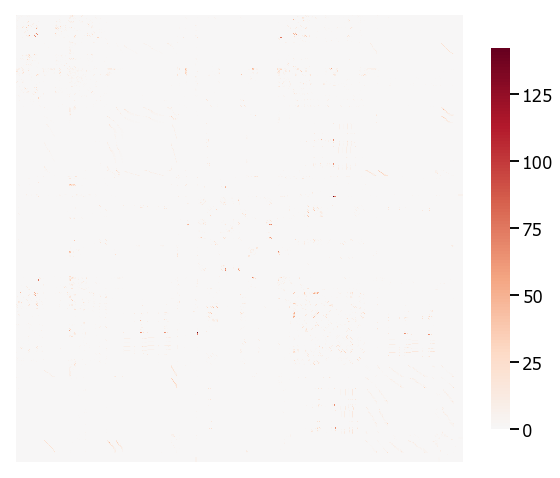

In [31]:
heatmap(chem)
plt.savefig('../../figures/celegans_chem_weighted.png', bbox_inches='tight')

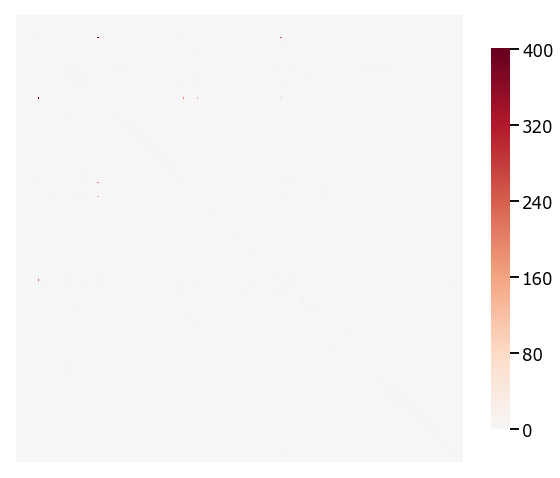

In [32]:
heatmap(gap)
plt.savefig('../../figures/celegans_gap_weighted.png', bbox_inches='tight')

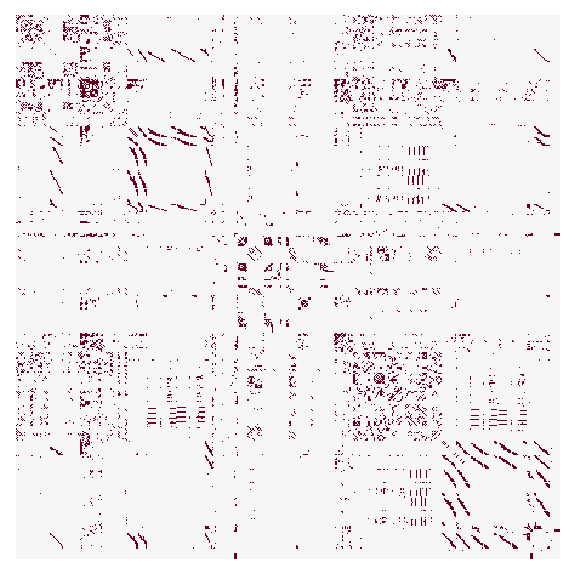

In [33]:
heatmap(chem_uw, cbar=False)
plt.savefig('../../figures/celegans_chem_unweighted.png', bbox_inches='tight')

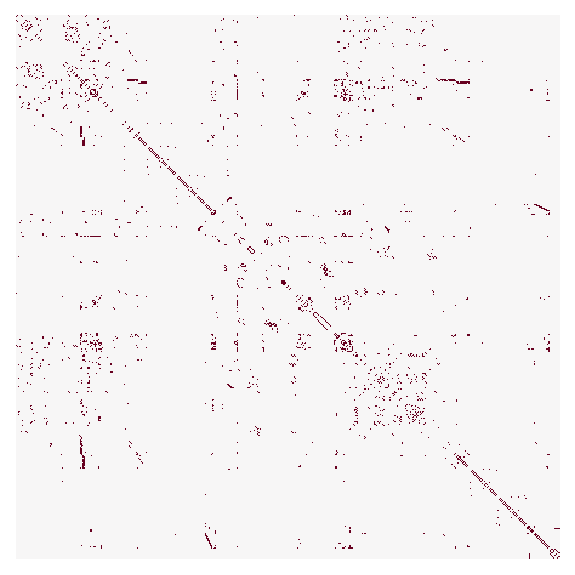

In [34]:
heatmap(gap_uw, cbar=False)
plt.savefig('../../figures/celegans_gap_unweighted.png', bbox_inches='tight')

In [35]:
block_assignment_uw = estimate_block_assignment(chem_uw, gap_uw, k=256, set_k=False, num_repeats=10)

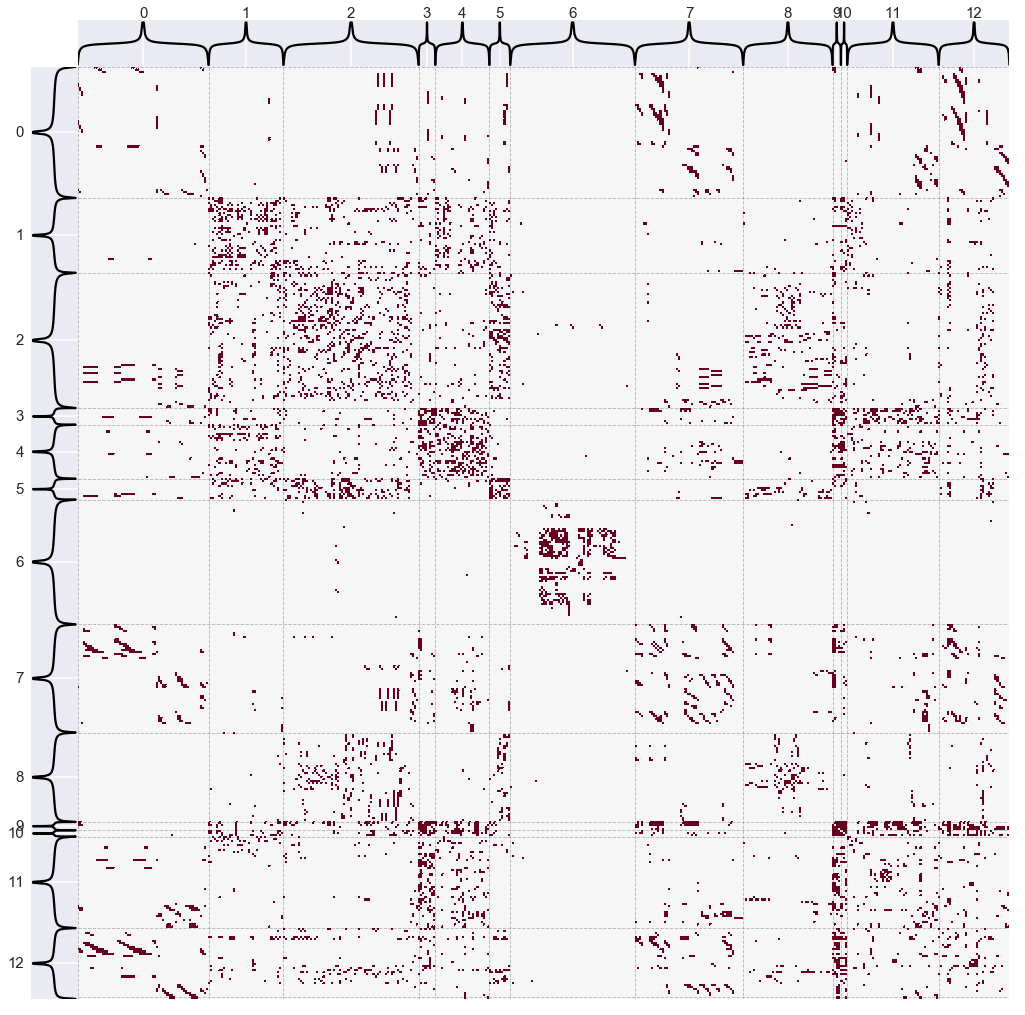

In [43]:
heatmap(chem_uw, inner_hier_labels=block_assignment_uw, cbar=False, figsize=(24, 18))
plt.savefig('../../figures/celegans_chem_unweighted_block.png', bbox_inches='tight')

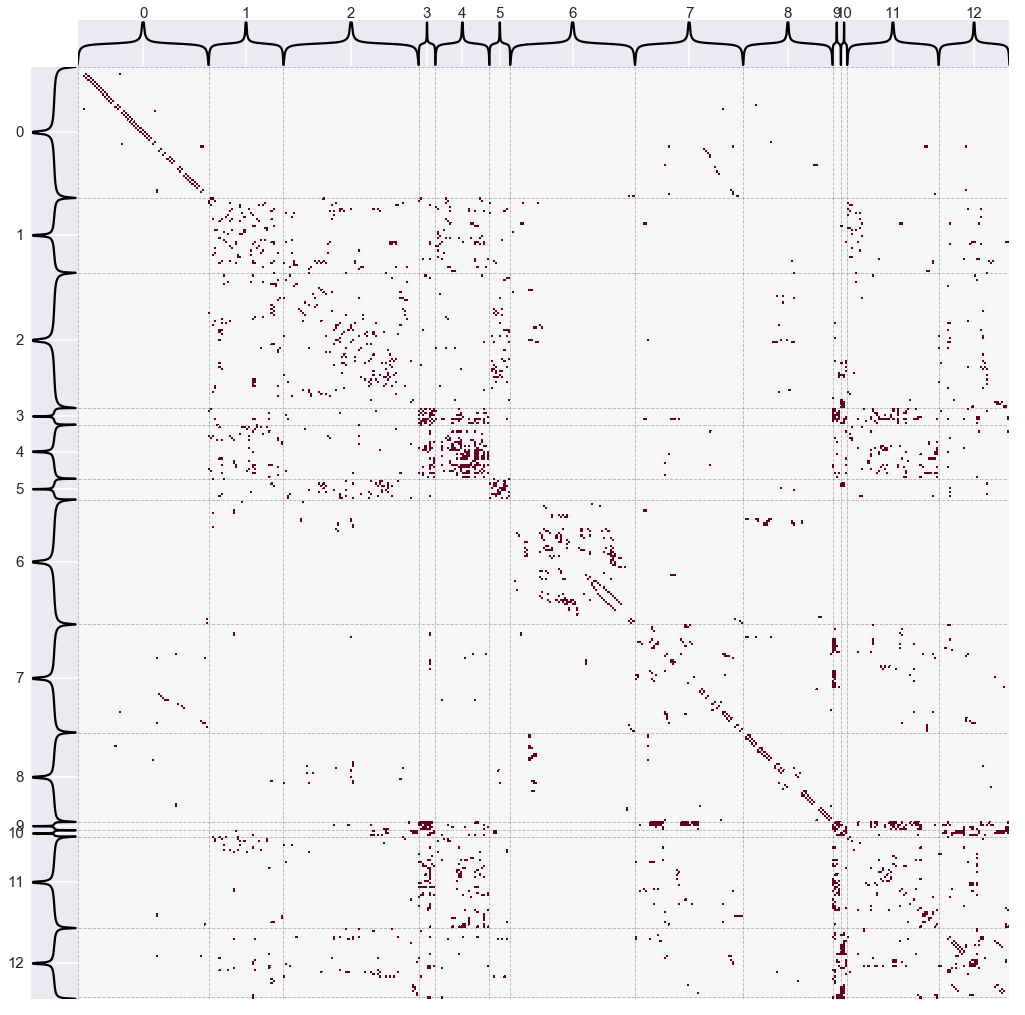

In [44]:
heatmap(gap_uw, inner_hier_labels=block_assignment_uw, cbar=False, figsize=(24, 18))
plt.savefig('../../figures/celegans_gap_unweighted_block.png', bbox_inches='tight')

In [51]:
mpl.style.use('seaborn')
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
legend_size = 16
label_size = 18

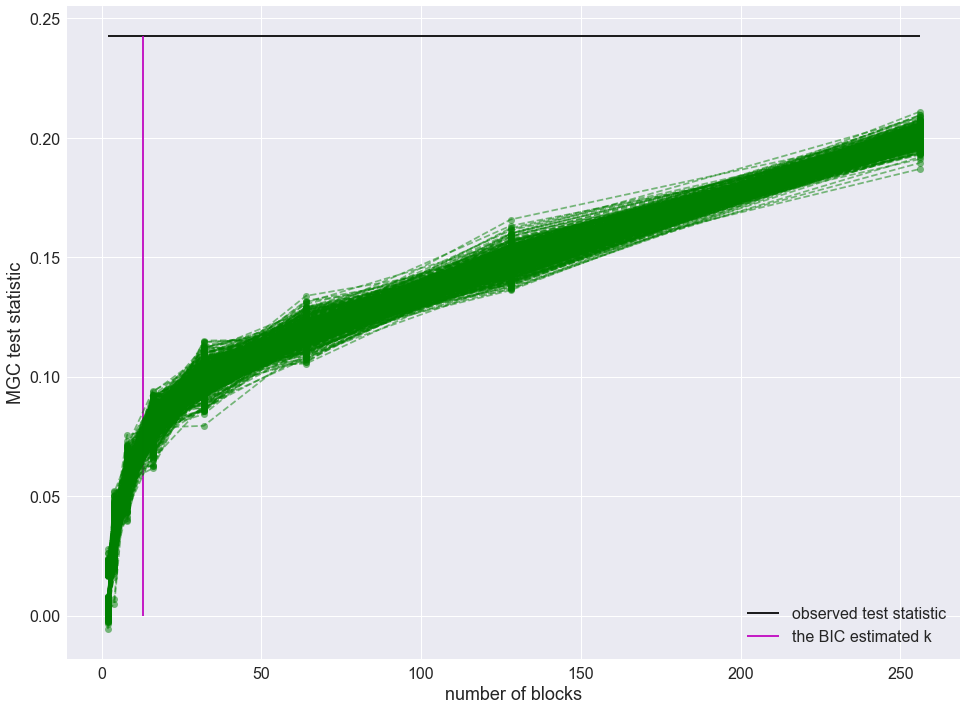

In [53]:
with open('../../results/celegans_chem_gap_unweighted_teststats_null.pkl', 'rb') as f:
    null = pickle.load(f)
null = dict(null)

k_arr = np.logspace(start=1, stop=8, num=8, base=2, dtype=int)
test_stats_null_arr = np.zeros((k_arr.size, 500))
for i, k in enumerate(k_arr):
    test_stats_null_arr[i, :] = null[k]

mgc = MGC(compute_distance_matrix=identity)
test_stats_alt, _ = mgc.test_statistic(to_distance_mtx(chem_uw), to_distance_mtx(gap_uw))
plt.figure(figsize=(16, 12))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='o', linestyle='--', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='observed test statistic')
plt.vlines(x=13, ymin=0, ymax=test_stats_alt, 
           label='the BIC estimated k', colors='m')
plt.xlabel('number of blocks', fontsize=label_size)
plt.ylabel('MGC test statistic', fontsize=label_size)
plt.legend(loc=4, prop={'size': legend_size})
plt.plot()
plt.savefig('../../figures/celegans_unweighted_ts.png', bbox_inches='tight')

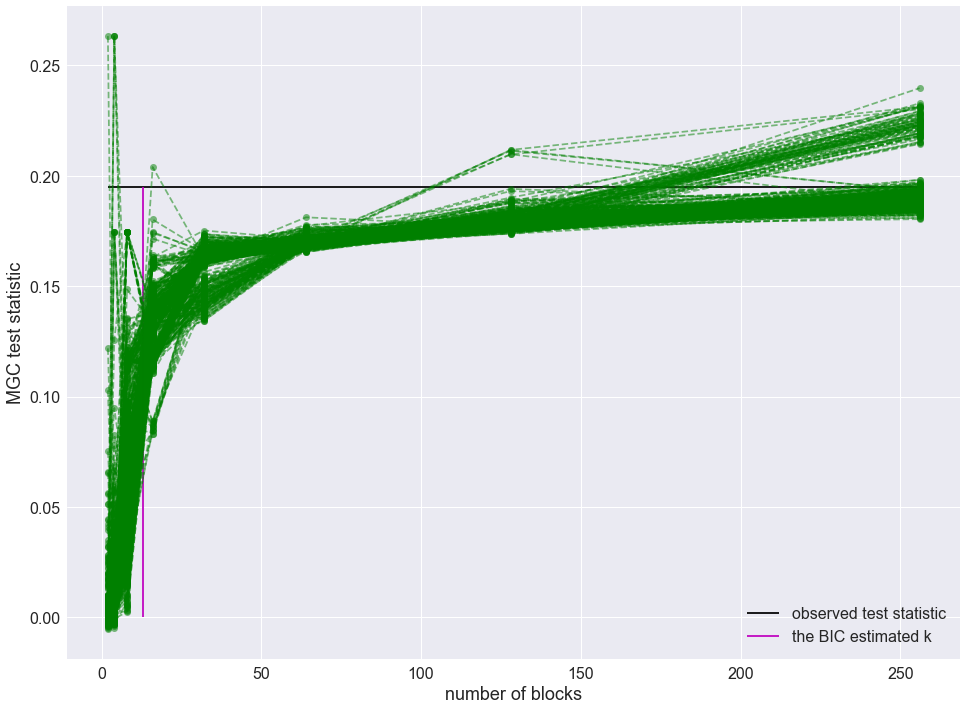

In [32]:
with open('../../results/celegans_chem_gap_weighted_teststats_null.pkl', 'rb') as f:
    null = pickle.load(f)
null = dict(null)

k_arr = np.logspace(start=1, stop=8, num=8, base=2, dtype=int)
test_stats_null_arr = np.zeros((k_arr.size, 500))
for i, k in enumerate(k_arr):
    test_stats_null_arr[i, :] = null[k]

mgc = MGC(compute_distance_matrix=identity)
test_stats_alt, _ = mgc.test_statistic(to_distance_mtx(chem), to_distance_mtx(gap))
plt.figure(figsize=(16, 12))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='o', linestyle='--', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='observed test statistic')
plt.vlines(x=np.unique(block_assignment_uw).size, ymin=0, ymax=test_stats_alt, 
           label='the BIC estimated k', colors='m')
plt.xlabel('number of blocks', fontsize=label_size)
plt.ylabel('MGC test statistic', fontsize=label_size)
plt.legend(loc=4, prop={'size': legend_size})
plt.plot()
plt.savefig('../../figures/celegans_weighted_ts.png', bbox_inches='tight')